# Generate Questions With GPT 3.5

In [1]:
import os
import json
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import openai

In [2]:
pl.Config(fmt_str_lengths=2000);

## Load the 200 Kaggle examples

In [3]:
df_test = pl.read_csv('data/train.csv')
df_test = df_test.drop(columns="id")
print(f'{df_test.shape[0]:,}')
df_test.columns

200


['prompt', 'A', 'B', 'C', 'D', 'E', 'answer']

In [4]:
options = ['A', 'B', 'C', 'D', 'E']
long_test = df_test.melt(['prompt', 'answer'], options, variable_name='option')
long_test = long_test.with_columns(long_test['value'].str.lengths().alias('answer_length'))
long_test = long_test.with_columns(long_test['prompt'].str.lengths().alias('question_length'))
long_test.columns

['prompt', 'answer', 'option', 'value', 'answer_length', 'question_length']

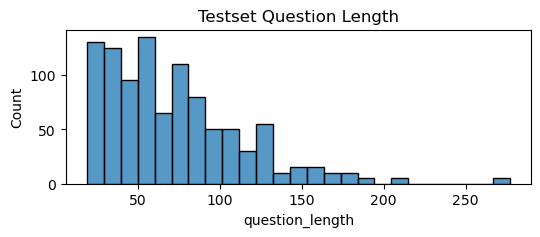

In [5]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='question_length')
plt.title('Testset Question Length');

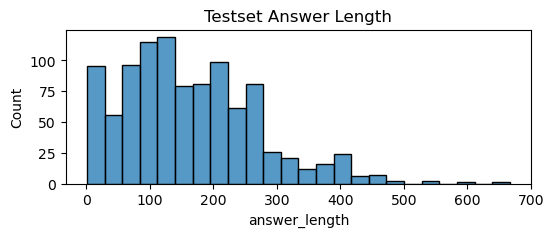

In [6]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='answer_length')
plt.title('Testset Answer Length');

## Load the Wikipedia data

In [7]:
pages = pl.read_parquet('./data/wiki_with_category.parquet')
print(f'{pages.shape[0]:,}')
pages.columns

153,622


['section_id',
 'title',
 'category',
 'page_id',
 'parent_id',
 'revision_id',
 'revision_ts',
 'short_description',
 'sha1',
 'page_bytes',
 'section_index',
 'section_title',
 'section_level',
 'section_text']

/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/transforms.py:2041: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/transforms.py:383: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


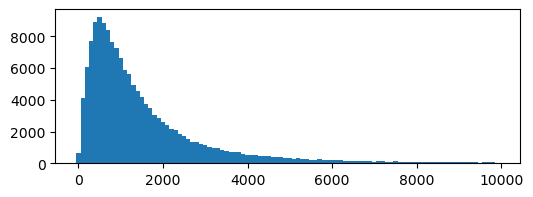

0.05: 154
0.25: 520
0.50: 1,022
0.66: 1,522
0.75: 1,955
0.90: 3,573
0.95: 5,252
0.99: 11,302


In [8]:
pages = pages.with_columns(pages['section_text'].str.lengths().alias('length'))
hist_output = pages['length'].hist(bins=range(0, 10000, 100))
bin_edges = hist_output['break_point']
counts = hist_output['length_count']

plt.subplots(figsize=(6,2))
plt.bar(bin_edges, counts, width=(bin_edges[1] - bin_edges[0]))
plt.show()

for p in [0.05, 0.25, 0.5, 0.66, 0.75, 0.9, 0.95, 0.99]:
    print(f"{p:.2f}: {pages['length'].quantile(p):,.0f}")

In [9]:
summaries = pages.filter(pl.col('section_title') == 'Summary')
summaries = summaries[['page_id', 'section_text']]
summaries = summaries.rename({'section_text':'summary'})
non_summaries = pages.filter(pl.col('section_title') != 'Summary')
with_summaries = non_summaries.join(summaries, how='left', on='page_id')

In [10]:
sample_size = 10000
max_section_length = 3600
wiki_sample = with_summaries[['title', 'section_title', 'length', 'summary', 'section_text']].sample(sample_size)
wiki_sample = wiki_sample.with_columns(pl.when(cs.string().str.lengths() >= max_section_length)\
                                         .then('[*] ' + cs.string().str.slice(0, max_section_length))\
                                         .otherwise(cs.string())\
                                         .keep_name())
#with pl.Config(fmt_str_lengths=5000):
#    display(sample[:3])
wiki_sample.columns
#wiki_sample.write_parquet('./data/wiki_samples_for_questions.parquet')

['title', 'section_title', 'length', 'summary', 'section_text']

In [11]:
wiki_sample = pl.read_parquet('./data/wiki_samples_for_questions.parquet')
sample_questions = df_test.sample(sample_size, with_replacement=True)
all_new_rows = []
for row in sample_questions.iter_rows(named=True):
    incorrect = []
    for letter in options:
        if letter == row['answer']:
            correct = row[letter]
        else:
            incorrect.append(row[letter])
    
    new_row = {'prompt': row['prompt'], 'correct': correct}
    for i in range(4):
        new_row[f'incorrect_{i+1}'] = incorrect[i]
    all_new_rows.append(new_row)

    
sample_questions = pl.DataFrame(all_new_rows)
sample_questions[:1]

prompt,correct,incorrect_1,incorrect_2,incorrect_3,incorrect_4
str,str,str,str,str,str
"""What is the difference between illuminance and luminance?""","""Illuminance is the amount of light falling on a surface per unit area, while luminance is the amount of light emitted by a source per unit area.""","""Illuminance is the amount of light absorbed by a surface per unit area, while luminance is the amount of light reflected by a surface per unit area.""","""Illuminance is the amount of light concentrated into a smaller area, while luminance is the amount of light filling a larger solid angle.""","""Illuminance is the amount of light emitted by a source per unit area, while luminance is the amount of light falling on a surface per unit area.""","""Illuminance is the amount of light reflected by a surface per unit area, while luminance is the amount of light absorbed by a surface per unit area."""


In [12]:
def wiki_section_to_prompt(section_row, question_row):
    return f'''
You are a psychometrics researcher designing a test to check the reasoning abilities of PHD students in STEM fields. 
Create multiple choice question that are very hard to answer from the Wikipedia snippet below, with 5 options which are 
concise, complex and ideally more than 150 to 300 charachters long. 

Provide only one correct option. The options should include only one correct statement and the other statements should be incorrect.
A partial response that is missing an aspect is not incorrect. All but one statement need to incluse a false assertion. 

Make sure at least one incorrect answers is longer than the correct answer. The answer can't be the option with the most charachters.

Example:
{{
    "question": "{question_row['prompt']}",
    "correct": "{question_row['correct']}",
    "incorrect_1": "{question_row['incorrect_1']}",
    "incorrect_2": "{question_row['incorrect_2']}",
    "incorrect_3": "{question_row['incorrect_3']}",
    "incorrect_4": "{question_row['incorrect_4']}"
}}

Use the following section of an Wikipedia article to inspire the question. In case the section is too specific, below there is also the summary of the page. 

Section: {section_row['title']}
{section_row['summary']}

Summary of: {section_row['section_title']}
{section_row['section_text']}
'''

In [13]:
mc5_schema = {
  "name": "dummy_function",
  "parameters": {
      "description": "A multiple choice question with 5 possible answers.",
      "type": "object",
      "properties": {
        "question": {},
        "correct": {},
        "incorrect_1": {},
        "incorrect_2": {},
        "incorrect_3": {},
        "incorrect_4": {}
      },
      "required": ["question", "correct",  "incorrect_1", "incorrect_2", "incorrect_3", "incorrect_4"]
    }
}

# check_mc6_schema = {
#   "name": "dummy_function",
#   "parameters": {
#       "type": "object",
#       "properties": {
#         "variable_answer_part": {"type": "string"},
#         "correct": {"type": "string"},
#         "reason_A": {"type": "string"},
#         "A": {"type": "boolean"},
#         "reason_B": {"type": "string"},
#         "B": {"type": "boolean"},
#         "reason_C": {"type": "string"},
#         "C": {"type": "boolean"},
#         "reason_D": {"type": "string"},
#         "D": {"type": "boolean"},
#         "reason_E": {"type": "string"},
#         "E": {"type": "boolean"},
#         "reason_F": {"type": "string"},
#         "F": {"type": "boolean"}
#       },
#       "required": ["variable_answer_part", "correct", "reason_A", "A", "reason_B", "B", "reason_C", "C", "reason_D", "D", "reason_E", "E", "reason_F", "F"]
#     }
# }

In [14]:
openai.api_key = os.environ['OPENAI_API_KEY']
def ask_chat_gpt(prompt, schema=None, gpt4=False):
    if gpt4:
        model = 'gpt-4-0613'
    else:
        model = 'gpt-3.5-turbo-0613'
        if schema is None:
            functions = None
            function_call = None
        else:
            functions = [schema]       
            function_call = {
                     "name": "dummy_function"
            }
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "user", "content": f"{prompt}"}
            ],
            functions=functions,
            function_call=function_call,
            max_tokens=1500
    )
        
    response_message = response["choices"][0]["message"]
    if schema is None:
        return response_message["content"]
    else:
        return response_message['function_call']['arguments']

In [19]:
n_chunk = 25
for i in range(300, 400):
    lower = n_chunk*i
    upper = n_chunk*(i+1)
    print(i, lower, upper-1)
    questions = []
    
    wiki_and_example_questions = list(zip(wiki_sample.iter_rows(named=True), sample_questions.iter_rows(named=True)))
    try:
        for section_row, question_row in tqdm(wiki_and_example_questions[lower:upper]):
            # print(section_row['title'], section_row['section_title'])       
            prompt = wiki_section_to_prompt(section_row, question_row)
            questions.append(ask_chat_gpt(prompt, mc5_schema))
        file_path = f'./data/daniel_train/v_1/{lower:05d}-{upper-1:05d}.csv'
        df_q = pl.from_dicts([json.loads(q_str) for q_str in questions])
        df_q = df_q.with_columns(wiki_sample[lower:upper]['title'], wiki_sample[lower:upper]['section_title'])
        df_q.write_csv(file_path)
        
    except Exception as e:
        print(e)

300 7500 7524


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 552)
301 7525 7549


  0%|          | 0/25 [00:00<?, ?it/s]

302 7550 7574


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 1041)
303 7575 7599


  0%|          | 0/25 [00:00<?, ?it/s]

304 7600 7624


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
305 7625 7649


  0%|          | 0/25 [00:00<?, ?it/s]

306 7650 7674


  0%|          | 0/25 [00:00<?, ?it/s]

307 7675 7699


  0%|          | 0/25 [00:00<?, ?it/s]

308 7700 7724


  0%|          | 0/25 [00:00<?, ?it/s]

309 7725 7749


  0%|          | 0/25 [00:00<?, ?it/s]

310 7750 7774


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
311 7775 7799


  0%|          | 0/25 [00:00<?, ?it/s]

312 7800 7824


  0%|          | 0/25 [00:00<?, ?it/s]

313 7825 7849


  0%|          | 0/25 [00:00<?, ?it/s]

314 7850 7874


  0%|          | 0/25 [00:00<?, ?it/s]

315 7875 7899


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
316 7900 7924


  0%|          | 0/25 [00:00<?, ?it/s]

317 7925 7949


  0%|          | 0/25 [00:00<?, ?it/s]

318 7950 7974


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 351)
319 7975 7999


  0%|          | 0/25 [00:00<?, ?it/s]

320 8000 8024


  0%|          | 0/25 [00:00<?, ?it/s]

321 8025 8049


  0%|          | 0/25 [00:00<?, ?it/s]

322 8050 8074


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 676)
323 8075 8099


  0%|          | 0/25 [00:00<?, ?it/s]

324 8100 8124


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
325 8125 8149


  0%|          | 0/25 [00:00<?, ?it/s]

326 8150 8174


  0%|          | 0/25 [00:00<?, ?it/s]

327 8175 8199


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 390)
328 8200 8224


  0%|          | 0/25 [00:00<?, ?it/s]

329 8225 8249


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting ',' delimiter: line 5 column 111 (char 461)
330 8250 8274


  0%|          | 0/25 [00:00<?, ?it/s]

331 8275 8299


  0%|          | 0/25 [00:00<?, ?it/s]

332 8300 8324


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
333 8325 8349


  0%|          | 0/25 [00:00<?, ?it/s]

334 8350 8374


  0%|          | 0/25 [00:00<?, ?it/s]

This model's maximum context length is 4097 tokens. However, you requested 4322 tokens (2762 in the messages, 60 in the functions, and 1500 in the completion). Please reduce the length of the messages, functions, or completion.
335 8375 8399


  0%|          | 0/25 [00:00<?, ?it/s]

336 8400 8424


  0%|          | 0/25 [00:00<?, ?it/s]

337 8425 8449


  0%|          | 0/25 [00:00<?, ?it/s]

338 8450 8474


  0%|          | 0/25 [00:00<?, ?it/s]

339 8475 8499


  0%|          | 0/25 [00:00<?, ?it/s]

340 8500 8524


  0%|          | 0/25 [00:00<?, ?it/s]

341 8525 8549


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 759)
342 8550 8574


  0%|          | 0/25 [00:00<?, ?it/s]

343 8575 8599


  0%|          | 0/25 [00:00<?, ?it/s]

344 8600 8624


  0%|          | 0/25 [00:00<?, ?it/s]

345 8625 8649


  0%|          | 0/25 [00:00<?, ?it/s]

346 8650 8674


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting ',' delimiter: line 7 column 180 (char 1086)
347 8675 8699


  0%|          | 0/25 [00:00<?, ?it/s]

348 8700 8724


  0%|          | 0/25 [00:00<?, ?it/s]

349 8725 8749


  0%|          | 0/25 [00:00<?, ?it/s]

350 8750 8774


  0%|          | 0/25 [00:00<?, ?it/s]

351 8775 8799


  0%|          | 0/25 [00:00<?, ?it/s]

352 8800 8824


  0%|          | 0/25 [00:00<?, ?it/s]

353 8825 8849


  0%|          | 0/25 [00:00<?, ?it/s]

354 8850 8874


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
355 8875 8899


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 1030)
356 8900 8924


  0%|          | 0/25 [00:00<?, ?it/s]

357 8925 8949


  0%|          | 0/25 [00:00<?, ?it/s]

358 8950 8974


  0%|          | 0/25 [00:00<?, ?it/s]

359 8975 8999


  0%|          | 0/25 [00:00<?, ?it/s]

360 9000 9024


  0%|          | 0/25 [00:00<?, ?it/s]

361 9025 9049


  0%|          | 0/25 [00:00<?, ?it/s]

362 9050 9074


  0%|          | 0/25 [00:00<?, ?it/s]

363 9075 9099


  0%|          | 0/25 [00:00<?, ?it/s]

364 9100 9124


  0%|          | 0/25 [00:00<?, ?it/s]

365 9125 9149


  0%|          | 0/25 [00:00<?, ?it/s]

366 9150 9174


  0%|          | 0/25 [00:00<?, ?it/s]

367 9175 9199


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 462)
368 9200 9224


  0%|          | 0/25 [00:00<?, ?it/s]

369 9225 9249


  0%|          | 0/25 [00:00<?, ?it/s]

370 9250 9274


  0%|          | 0/25 [00:00<?, ?it/s]

371 9275 9299


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
372 9300 9324


  0%|          | 0/25 [00:00<?, ?it/s]

373 9325 9349


  0%|          | 0/25 [00:00<?, ?it/s]

Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sun, 10 Sep 2023 14:26:47 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '804859134810ca70-HAM', 'alt-svc': 'h3=":443"; ma=86400'}
374 9350 9374


  0%|          | 0/25 [00:00<?, ?it/s]

375 9375 9399


  0%|          | 0/25 [00:00<?, ?it/s]

376 9400 9424


  0%|          | 0/25 [00:00<?, ?it/s]

377 9425 9449


  0%|          | 0/25 [00:00<?, ?it/s]

378 9450 9474


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 399)
379 9475 9499


  0%|          | 0/25 [00:00<?, ?it/s]

380 9500 9524


  0%|          | 0/25 [00:00<?, ?it/s]

381 9525 9549


  0%|          | 0/25 [00:00<?, ?it/s]

382 9550 9574


  0%|          | 0/25 [00:00<?, ?it/s]

383 9575 9599


  0%|          | 0/25 [00:00<?, ?it/s]

384 9600 9624


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 496)
385 9625 9649


  0%|          | 0/25 [00:00<?, ?it/s]

This model's maximum context length is 4097 tokens. However, you requested 4178 tokens (2618 in the messages, 60 in the functions, and 1500 in the completion). Please reduce the length of the messages, functions, or completion.
386 9650 9674


  0%|          | 0/25 [00:00<?, ?it/s]

Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
387 9675 9699


  0%|          | 0/25 [00:00<?, ?it/s]

Invalid \escape: line 3 column 21 (char 87)
388 9700 9724


  0%|          | 0/25 [00:00<?, ?it/s]

389 9725 9749


  0%|          | 0/25 [00:00<?, ?it/s]

390 9750 9774


  0%|          | 0/25 [00:00<?, ?it/s]

391 9775 9799


  0%|          | 0/25 [00:00<?, ?it/s]

392 9800 9824


  0%|          | 0/25 [00:00<?, ?it/s]

393 9825 9849


  0%|          | 0/25 [00:00<?, ?it/s]

394 9850 9874


  0%|          | 0/25 [00:00<?, ?it/s]

395 9875 9899


  0%|          | 0/25 [00:00<?, ?it/s]

Expecting property name enclosed in double quotes: line 8 column 1 (char 840)
396 9900 9924


  0%|          | 0/25 [00:00<?, ?it/s]

397 9925 9949


  0%|          | 0/25 [00:00<?, ?it/s]

This model's maximum context length is 4097 tokens. However, you requested 4111 tokens (2551 in the messages, 60 in the functions, and 1500 in the completion). Please reduce the length of the messages, functions, or completion.
398 9950 9974


  0%|          | 0/25 [00:00<?, ?it/s]

399 9975 9999


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# file_path = f'./data/daniel_train_aug_19_200-300.csv'
# df_q = pl.from_dicts([json.loads(q_str) for q_str in questions])
# df_q = df_q.with_columns(wiki_sample[100:200]['title'], wiki_sample[100:200]['section_title'])
# df_q.write_csv(file_path)

In [ ]:
update_file = True
file_path = './data/daniel_train_aug_19_800.parquet'
if update_file:
    df_q = pl.from_dicts([json.loads(q_str) for q_str in questions])
    df_q = df_q.with_columns(sample['title'], sample['section_title'])
    #df_q_disk = pl.read_parquet('./data/daniel_train_aug_17.parquet')
    #df_q_disk = pl.concat([df_q_disk, df_q])
    df_q.write_parquet(file_path)
else:
    df_q = pl.read_parquet(file_path)

In [ ]:
#df_q

In [74]:
ordered_opt = ['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'incorrect_5']
long_q = df_q.melt(['question'], ordered_opt, variable_name='option')
long_q = long_q.with_columns(long_q['value'].str.lengths().alias('answer_length'))
long_q = long_q.with_columns(long_q['question'].str.lengths().alias('question_length'))
long_q[:3]

question,option,value,answer_length,question_length
str,str,str,u32,u32
"""In mathematics, what is an iterated function?""","""correct""","""An iterated function is a function obtained by composing another function with itself a certain number of times.""",112,45
"""What is a major focus of the Mathematical Biosciences Institute (MBI)?""","""correct""","""MBI organizes Emphasis Semesters consisting of three or four week-long workshops.""",81,70
"""What does Bochner's theorem in mathematics characterize?""","""correct""","""Bochner's theorem characterizes the Fourier transform of a positive finite Borel measure on the real line.""",106,56


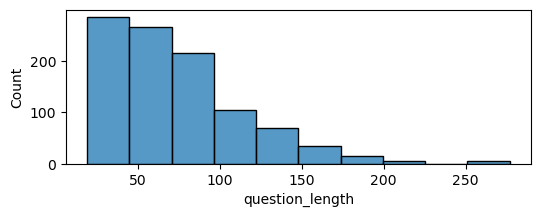

In [75]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='question_length', bins=10);

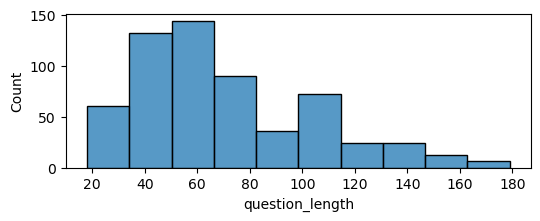

In [76]:
plt.figure(figsize=(6,2))
sns.histplot(long_q, x='question_length', bins=10);

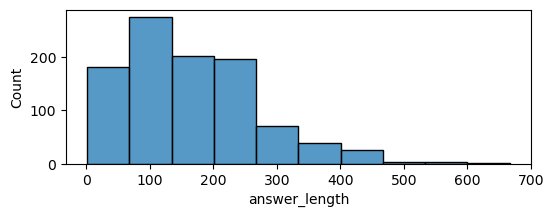

In [63]:
plt.figure(figsize=(6,2))
sns.histplot(long_test, x='answer_length', bins=10);

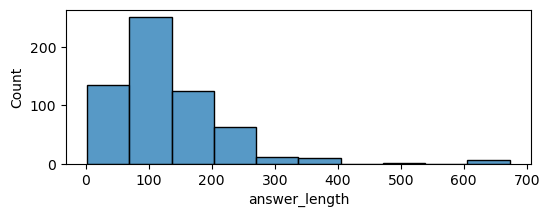

In [17]:
plt.figure(figsize=(6,2))
sns.histplot(long_q, x='answer_length', bins=10);

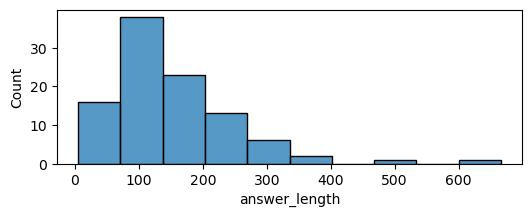

In [18]:
plt.figure(figsize=(6,2))
sns.histplot(long_q.filter(pl.col('option') == 'correct'), x='answer_length', bins=10);

## Use GPT-3.5-turbo to remove incorrect answers

In [21]:
# Example:
# {{
#     "question": "{question_row['prompt']}",
#     "justification": "
#         1. Placeholder for an explanation why the original answer under the key "correct" is either correct or not.
#         2. Placeholder for an explanation why the original answer under the key "incorrect_1" is either correct or not. 
#         3. Placeholder for an explanation why the original answer under the key "incorrect_2" is either correct or not. 
#         4. Placeholder for an explanation why the original answer under the key "incorrect_3" is either correct or not. 
#         5. Placeholder for an explanation why the original answer under the key "incorrect_4" is either correct or not.
#         6. Placeholder for an explanation why the original answer under the key "incorrect_5" is either correct or not.     
#     ",
#     "new_correct": "New correct option text",
#     "new_incorrect_1": "New incorrect_1 option text",
#     "incorrect_2": "New incorrect_2 option text",
#     "new_incorrect_3": "New incorrect_3 option text",
#     "new_incorrect_4": "New incorrect_4 option text"
# }}

In [22]:
# You are a psychometrics researcher designing a test to check the reasoning abilities of graduates in STEM fields. 
# Improve a given multiple choice question with 5 options from an example with 6 options. The answers should be 
# concise, complex and ideally 100 to 300 charachters long. 

# Provide only one correct option with the key "new_correct". The other options which have keys starting with "new_incorrect_" should only be incorrect statements.
# A partial response that is missing an aspect is not conisdered incorrect for this task. Make sure at least one incorrect answers is longer than the correct answer.

# First go through the options provided at the end of this prompt and provide a justification for each option one by one. Explaining why each option is correct or incorrect.
# Provide the justifications for all options in one text field called justification.

# In the second step output improved answeres, by omitting or replacing correct answers under the keys starting with  "incorrect_". 
# If any answer under the keys starting with "incorrect_" is actually correct drop it. If multiple answers get dropped, create new incorrect options.

# Lastly please rate the difficulty of the questions on a scale from 1 to 10. The diffculty should be seen from an expert perspective. A 5 would be a questions which most people at graduate level
# who have studied the subject can answer, but people who have not had trainging in the subject can not answe. Again the test is for graduates, so even a 3 should be a hard question. 

# Here is the original question to improve on, this is not an example for the output format. The output has one incorrect answer less and additinoal fields for the justificaiton and the difficulty:


In [445]:
# def check_mc6_prompt(question_row):
#     return f'''
# {{
# "question": "{question_row['question']}",
# "A": "{question_row['incorrect_1']}",
# "B": "{question_row['incorrect_2']}",
# "C": "{question_row['correct']}",
# "D": "{question_row['incorrect_3']}",
# "E": "{question_row['incorrect_4']}",
# "F": "{question_row['incorrect_5']}"
# }}

# First check if the answers A to F have parts that are similar to each other and parts that are different between them.
# Describe the part the ist different between the answers in the output field different_answer_part.
# Consiely describe the correct version for the part that is different between the question in the field correct.
# Explain each reason why each answers below is correct or incorrect in a few keywords in the fields reason_A to reason_F. 
# In each of the fields reason_A to reason_F provide a step by step reasoning why the answers A to F below are correct or incorrect.
# Describe each step with 3 to 5 keywords.

# Output a valid JSON message. Example:
# {{
#     "different_answer_part": "[Part that differs between the answers A to F.]",
#     "correct": "[correct version for the part that is different between the question in a few keywords]",
#     "reason_A": "[Concise step by step reasoning why the answer A is correct or incorrect]",
#     "A": [true or false based on answer A],
#     "reason_B": "[Concise step by step reasoning why the answer B is correct or incorrect]",
#     "B": [true or false based on answer B],
#     ...
# }}
# '''

In [479]:
def check_question_prompt(question_row):
    return f'''

question: {question_row['question']}
A: {question_row['incorrect_1']}
B: {question_row['incorrect_2']}
C: {question_row['correct']}
D: {question_row['incorrect_3']}
E: {question_row['incorrect_4']}
F: {question_row['incorrect_5']}


Output a valid JSON message. First describe the correct answer in 2-5 keywords an output the result in the field correct.

Example:
{{
    "correct": "[Consicely describe the correct answer, ideally in just a few keywords]"
    "A": [true or false based on answer A],
    "B": [true or false based on answer B],
    "C": [true or false based on answer C],
    "D": [true or false based on answer D],
    "E": [true or false based on answer E],
    "F": [true or false based on answer F]
}}
'''

In [483]:
refine_prompts = []
refined_qs = []
for question_row in df_q[:20].iter_rows(named=True): 
    print('.')
    prompt = check_question_prompt(question_row)
    refine_prompts.append(prompt)
    refined_qs.append(ask_chat_gpt(prompt, check_mc6_schema))

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [485]:
df_check = pl.DataFrame([json.loads(obj) for obj in refined_qs])

In [487]:
df_check.sum()

correct,A,B,C,D,E,F
str,u32,u32,u32,u32,u32,u32
null,3,1,17,1,2,2


In [482]:
print(refine_prompts[1])



question: Based on Birch's law, which of the following statements accurately describes the relationship between compressional wave velocity and density in rocks and minerals?
A: According to Birch's law, the compressional wave velocity in rocks and minerals is inversely related to the density, with higher density materials having higher wave velocities.
B: According to Birch's law, the compressional wave velocity in rocks and minerals is unrelated to the density, as the velocity is only determined by the mean atomic mass of the material.
C: According to Birch's law, the compressional wave velocity in rocks and minerals is linearly related to the density, with the velocity being determined by the mean atomic mass and the density of the material.
D: According to Birch's law, the compressional wave velocity in rocks and minerals is non-linearly related to the density, with the velocity being determined by other factors such as temperature and pressure.
E: According to Birch's law, the c